In [25]:
# import tensorflow as tf



#### References
###### Data source for project --- > http://ai.bu.edu/M3SDA/

#### Approaches
###### https://medium.com/analytics-vidhya/image-classification-with-tensorflow-2a406bdfe0c1
###### https://towardsdatascience.com/fine-tuning-a-cnn-model-for-image-classification-a886e4b539b3
###### https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
###### https://www.tensorflow.org/tutorials/load_data/images
###### https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752
###### Setting up reproduceable environment https://github.com/keras-team/keras/issues/2743

In [1]:
seed_value=765
import shutil
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['CUDA_VISIBLE_DEVICES']='-1'
os.environ['TF_CUDNN_USE_AUTORUNE']='0'
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [27]:
from pathlib import Path
file_path=Path.cwd()

In [28]:
file_path

PosixPath('/geode2/home/u010/adijames/Carbonate/Desktop/project')

### Import train and test file paths to create folder structure

In [29]:
with open('/geode2/home/u010/adijames/Carbonate/Desktop/project/train.txt', 'r') as f:
        train_files = []
        for ele in f:
            line = ele.split()
            if len(line)>0:
                train_files.append(line[0])


len(train_files)

33525

In [30]:
with open('/geode2/home/u010/adijames/Carbonate/Desktop/project/test.txt', 'r') as f:
        test_files = []
        for ele in f:
            line = ele.split()
            if len(line)>0:
                test_files.append(line[0])
len(test_files)

14604

In [31]:
folders={}

for i in train_files:
    x=i
    y=x.replace("clipart/","").split("/")[0]
    if folders.get(y,None) == None:
        # {"POS":{"word":1}}
        folders.update({y:1})
    else:
        folders[y]+=1

list_folders=list(folders.keys())
# list_folders
num_samples=[]
for i,j in enumerate(folders.items()):
    
    num_samples.append(j)
# print(num_samples)


In [32]:
x_val=list(folders.keys())
y_val=list(folders.values())

In [33]:
#function to select only those categories that satisfy a specific sample threshold
def images_to_process(x_val,y_val,threshold):
    cats_2_explore=[]
    number_samples=[]
    for i in zip(x_val,y_val):
        if i[1]>threshold:
            cats_2_explore.append(i[0])
            number_samples.append(i[1])
            
    print("number of classes:",len(cats_2_explore))

    return(cats_2_explore,number_samples)          

In [34]:
#function to plot the number of samples to understand the distribution of the data
def box_plot(y_val):
    fig, ax = plt.subplots()
    fig.set_size_inches(5,8)
    num_class=len(y_val)
    title='Distribution of samples within the '+str(num_class)+' classes'
    ax.set_title(title,fontsize=20)
    ax.set_xlabel('Clipart images',fontsize=20)
    ax.set_ylabel('Number of images',fontsize=20)
    plt.boxplot(y_val)
    plt.show()
    return

number of classes: 17


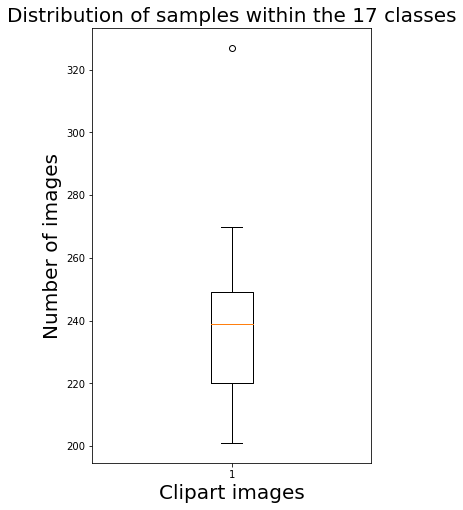

In [35]:
category,samples=images_to_process(x_val,y_val,200)
box_plot(samples)

##### We see that there are a median of 240 images for each class. We think that this might require us to try out some sampling techniques in order to increase the number of samples for each class. 

#### Creating folders to move training and test data

In [36]:
# Run only at the start to create the folder structure

# for i in list_folders:

#     train_fld='/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/train/'+i
#     test_fld='/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/test/'+i
#     os.makedirs(train_fld)
#     os.makedirs(test_fld)
    
    

### Copy images to the train and test folders

##### Copy train images

In [37]:
# #One time run to copy training files
# for x in train_files:
#     x=x.replace("clipart/","")
#     frm_loc='/geode2/home/u010/adijames/Carbonate/Desktop/project/clipart/'+x
#     to_loc='/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/train/'+x
#     # print("frm_loc=",frm_loc)
#     # print("to_loc=",to_loc)
#     shutil.copyfile(frm_loc, to_loc)


##### Copy test images

In [38]:
# # One time run to copy test files
# for x in test_files:
#     x=x.replace("clipart/","")
#     frm_loc='/geode2/home/u010/adijames/Carbonate/Desktop/project/clipart/'+x
#     to_loc='/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/test/'+x
#     # print("frm_loc=",frm_loc)
#     # print("to_loc=",to_loc)
#     shutil.copyfile(frm_loc, to_loc)

In [39]:
# # One time run to move selected classes for analysis

# training_path_='/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/train/'
# training_path_select_='/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/train_select/'
# testing_path_='/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/test/'
# testing_path_select_='/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/test_select/'

# cnt=0
# for i in category:
#     from_path=training_path_+i
#     to_path=training_path_select_+i
#     shutil.move(from_path,to_path)
    
#     from_path_test=testing_path_+i
#     to_path_test=testing_path_select_+i
#     shutil.move(from_path_test,to_path_test)
    
#     cnt+=1
    
#     if cnt%5==0:
#         print("moved ",cnt," folders")

#### Data extraction and preparation

In [40]:
training_path='/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/train_select'
testing_path='/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/test_select'
seed=123

#setup for image type
color_mode = "grayscale"
number_colour_layers = 1
image_size = (64, 64)
# image_size = (128, 128)

image_shape = image_size + (number_colour_layers,)

In [41]:
def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    raw_data_set = \
    tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split, 
        subset=subset
    )
    
    raw_data_set.class_names.sort()
    
    return {
        "data": raw_data_set.cache().prefetch(
        buffer_size = tf.data.experimental.AUTOTUNE
        ),
        "classNames": raw_data_set.class_names
    }

In [42]:
training_ds = get_image_data(
    training_path,
    color_mode,
    image_size,
    seed,
    subset = "training"
)
validation_ds = get_image_data(
    training_path,
    color_mode,
    image_size,
    seed,
    subset = "validation"
)
test_ds = get_image_data(
    testing_path,
    color_mode,
    image_size
)

Found 4065 files belonging to 17 classes.
Using 3252 files for training.
Found 4065 files belonging to 17 classes.
Using 813 files for validation.
Found 1756 files belonging to 17 classes.


In [43]:
equivalence_check = training_ds["classNames"] == validation_ds["classNames"]
assert_fail_message = "Training and Validation classes should match"
assert(equivalence_check), assert_fail_message
class_names = training_ds["classNames"]
number_classes = len(class_names)

In [44]:
preprocessing_layers = [tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape)]

In [45]:
# def conv_2d_pooling_layers(filters, kernel_size,conv_strides,activation,pool_size,pool_strides):
#     return [
#         tf.keras.layers.Conv2D(
#             filters=filters,
#             kernel_size=kernel_size,
#             strides=conv_strides,
# #             padding='same',
#             activation=activation
#         ),
#         tf.keras.layers.MaxPooling2D(pool_size=pool_size,strides=pool_strides),
#         tf.keras.layers.Dropout(0.75)
#     ]
# # core_layers = \
# #     conv_2d_pooling_layers(16, number_colour_layers) + \
# #     conv_2d_pooling_layers(32, number_colour_layers) + \
# #     conv_2d_pooling_layers(64, number_colour_layers)
# core_layers = \
#     conv_2d_pooling_layers(6, 5,1,'relu',2,2) + \
#     conv_2d_pooling_layers(16, 5,1,'relu',2,2)


# dense_layers = [
#     tf.keras.layers.Flatten(),
# #     tf.keras.layers.Dense(120, activation='relu'),
#     tf.keras.layers.Dense(256, activation='relu'),
# #     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(number_classes,activation='softmax')
# ]


# model = tf.keras.Sequential(
#     preprocessing_layers +
#     core_layers +
#     dense_layers
# )



# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# model.compile(
#     optimizer='adam',
#     loss=loss,
#     metrics=['accuracy']
# )



# Architecture 1

In [46]:
#https://www.analyticsvidhya.com/blog/2021/05/image-classification-with-tensorflow-data-augmentation-on-streaming-data-part-2/
data_augmentation = [tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
#                      ,tf.keras.layers.experimental.preprocessing.RandomRotation((-0.2, 0.3))
]

------------------------- Model Summary -------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 64, 64, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 6)         156       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 6)        0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 30, 30, 6)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 16)       

/N/u/adijames/Carbonate/.conda/envs/adi_proj/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


102/102 [==============================] - 4s 26ms/step - loss: 2.8395 - accuracy: 0.0698 - val_loss: 2.8241 - val_accuracy: 0.0664
Epoch 2/200
102/102 [==============================] - 2s 16ms/step - loss: 2.7990 - accuracy: 0.0821 - val_loss: 2.8208 - val_accuracy: 0.0886
Epoch 3/200
102/102 [==============================] - 2s 16ms/step - loss: 2.7839 - accuracy: 0.0929 - val_loss: 2.8253 - val_accuracy: 0.0800
Epoch 4/200
102/102 [==============================] - 2s 15ms/step - loss: 2.7660 - accuracy: 0.1039 - val_loss: 2.8294 - val_accuracy: 0.0566
Epoch 5/200
102/102 [==============================] - 2s 15ms/step - loss: 2.7454 - accuracy: 0.1202 - val_loss: 2.7987 - val_accuracy: 0.0972
Epoch 6/200
102/102 [==============================] - 2s 16ms/step - loss: 2.7085 - accuracy: 0.1301 - val_loss: 2.7729 - val_accuracy: 0.1230
Epoch 7/200
102/102 [==============================] - 2s 15ms/step - loss: 2.6696 - accuracy: 0.1507 - val_loss: 2.7479 - val_accuracy: 0.1169
Epoc

102/102 [==============================] - 2s 15ms/step - loss: 1.9899 - accuracy: 0.3795 - val_loss: 2.2093 - val_accuracy: 0.3050
Epoch 114/200
102/102 [==============================] - 2s 15ms/step - loss: 2.0126 - accuracy: 0.3770 - val_loss: 2.1849 - val_accuracy: 0.3247
Epoch 115/200
102/102 [==============================] - 2s 15ms/step - loss: 1.9766 - accuracy: 0.3819 - val_loss: 2.2077 - val_accuracy: 0.3100
Epoch 116/200
102/102 [==============================] - 2s 15ms/step - loss: 1.9925 - accuracy: 0.3878 - val_loss: 2.2081 - val_accuracy: 0.3149
Epoch 117/200
102/102 [==============================] - 2s 15ms/step - loss: 2.0251 - accuracy: 0.3681 - val_loss: 2.1739 - val_accuracy: 0.3346
Epoch 118/200
102/102 [==============================] - 2s 15ms/step - loss: 2.0005 - accuracy: 0.3798 - val_loss: 2.2749 - val_accuracy: 0.2866
Epoch 119/200
102/102 [==============================] - 2s 15ms/step - loss: 1.9983 - accuracy: 0.3828 - val_loss: 2.1689 - val_accuracy:

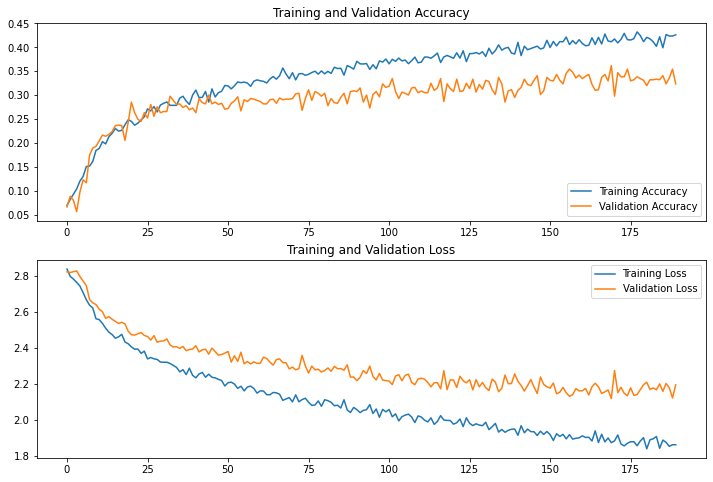

In [47]:
# This is the 1st draft of the model
def conv_2d_pooling_layers(filters, kernel_size,conv_strides,activation,pool_size,pool_strides):
    return [
        tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=conv_strides,
#             padding='same',
            activation=activation
        ),
        tf.keras.layers.MaxPooling2D(pool_size=pool_size,strides=pool_strides),
        tf.keras.layers.Dropout(0.75,seed=seed_value)
    ]
# core_layers = \
#     conv_2d_pooling_layers(16, number_colour_layers) + \
#     conv_2d_pooling_layers(32, number_colour_layers) + \
#     conv_2d_pooling_layers(64, number_colour_layers)
core_layers = \
    conv_2d_pooling_layers(6, 5,1,'relu',2,2) + \
    conv_2d_pooling_layers(16, 5,1,'relu',2,2)


dense_layers = [
    tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5,seed=seed_value),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25,seed=seed_value),
    tf.keras.layers.Dense(number_classes,activation='softmax')
]


model = tf.keras.Sequential(preprocessing_layers+data_augmentation +core_layers +dense_layers)
# model = tf.keras.Sequential(preprocessing_layers+core_layers +dense_layers)


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])

print("-"*25,"Model Summary","-"*25)
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto',
                                            baseline=None, restore_best_weights=True)
print("%%"*55)
print("##"*55)
print("-"*30,"Model Evaluation over Epochs","-"*30)
history = model.fit(training_ds["data"],validation_data = validation_ds["data"],epochs = 200,callbacks = [callback],shuffle=False)
print("%%"*55)

print("##"*55)
print("-"*25,"Test data evaluation","-"*25)
model.evaluate(test_ds["data"])
print("%%"*55)

print("##"*55)
print("-"*25,"Loss and Accuracy curves","-"*25)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Architecture 2

------------------------- Model Summary -------------------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 64, 64, 1)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 16)        160       
                                                                 
 batch_normalization_6 (Batc  (None, 62, 62, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        2320      
                                                                 
 batch_normalization_7 (Batc  (None, 60, 60, 16)      

102/102 [==============================] - 4s 42ms/step - loss: 2.7828 - accuracy: 0.3198 - val_loss: 3.7164 - val_accuracy: 0.1636
Epoch 82/300
102/102 [==============================] - 4s 42ms/step - loss: 2.7947 - accuracy: 0.3180 - val_loss: 2.8589 - val_accuracy: 0.3014
Epoch 83/300
102/102 [==============================] - 4s 42ms/step - loss: 2.7515 - accuracy: 0.3195 - val_loss: 3.0944 - val_accuracy: 0.2399
Epoch 84/300
102/102 [==============================] - 4s 42ms/step - loss: 2.7304 - accuracy: 0.3213 - val_loss: 3.2464 - val_accuracy: 0.2116
Epoch 85/300
102/102 [==============================] - 4s 42ms/step - loss: 2.6799 - accuracy: 0.3303 - val_loss: 4.4467 - val_accuracy: 0.1599
Epoch 86/300
102/102 [==============================] - 4s 42ms/step - loss: 2.6527 - accuracy: 0.3290 - val_loss: 3.0947 - val_accuracy: 0.2362
Epoch 87/300
102/102 [==============================] - 4s 42ms/step - loss: 2.6847 - accuracy: 0.3287 - val_loss: 3.5179 - val_accuracy: 0.190

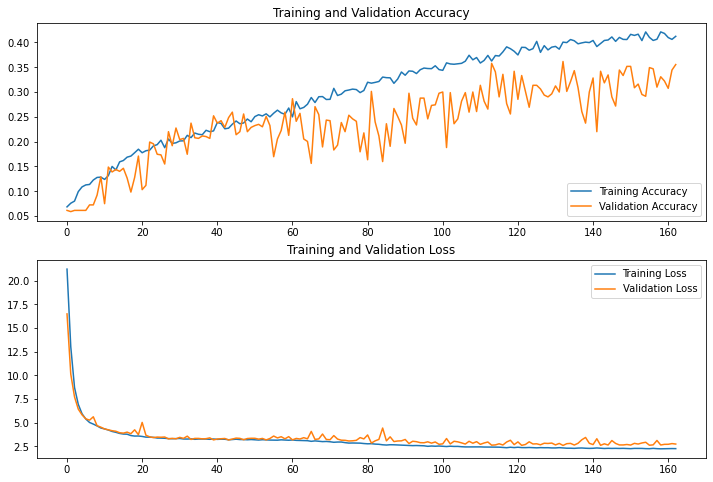

In [48]:
# initializer=tf.keras.initializers.HeUniform(seed=seed_value)
def conv_2d_pooling_layers(filters, kernel_size,conv_strides,activation,pool_size,pool_strides):
    return [
        tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=conv_strides,activation=activation
                               ,kernel_regularizer='l2'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=conv_strides,activation=activation
                               ,kernel_regularizer='l1_l2'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=pool_size,strides=pool_strides)
        ,tf.keras.layers.Dropout(0.6,seed=seed_value)
    ]


core_layers = \
    conv_2d_pooling_layers(16, 3,1,'relu',2,2) + \
    conv_2d_pooling_layers(32, 3,1,'relu',2,2) + \
    conv_2d_pooling_layers(64, 3,1,'relu',2,2)

#original
# core_layers = \
#     conv_2d_pooling_layers(3, 5,1,'relu',2,2) + \
#     conv_2d_pooling_layers(6, 5,1,'relu',2,2) 



dense_layers = [
    tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5,seed=seed_value),
    tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.25,seed=seed_value),
    tf.keras.layers.Dense(number_classes,activation='softmax')
]

model = tf.keras.Sequential(preprocessing_layers+data_augmentation +core_layers +dense_layers)
# model = tf.keras.Sequential(preprocessing_layers +core_layers +dense_layers)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])

print("-"*25,"Model Summary","-"*25)
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto',
                                            baseline=None, restore_best_weights=True)
print("%%"*55)
print("##"*55)
print("-"*30,"Model Evaluation over Epochs","-"*30)
history = model.fit(training_ds["data"],validation_data = validation_ds["data"],epochs = 300,callbacks = [callback],shuffle=False)
# history = model.fit(training_ds["data"],validation_data = validation_ds["data"],epochs = 50,shuffle=False)

print("%%"*55)

print("##"*55)
print("-"*25,"Test data evaluation","-"*25)
model.evaluate(test_ds["data"])
print("%%"*55)

print("##"*55)
print("-"*25,"Loss and Accuracy curves","-"*25)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Architecture 3

------------------------- Model Summary -------------------------
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 64, 64, 1)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 63, 63, 16)        80        
                                                                 
 batch_normalization_12 (Bat  (None, 63, 63, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 62, 62, 16)        1040      
                                                                 
 batch_normalization_13 (Bat  (None, 62, 62, 16)      

102/102 [==============================] - 3s 33ms/step - loss: 2.0248 - accuracy: 0.4228 - val_loss: 2.1956 - val_accuracy: 0.3776
Epoch 82/300
102/102 [==============================] - 3s 33ms/step - loss: 2.0186 - accuracy: 0.4268 - val_loss: 2.1202 - val_accuracy: 0.4096
Epoch 83/300
102/102 [==============================] - 3s 33ms/step - loss: 2.0042 - accuracy: 0.4446 - val_loss: 2.2959 - val_accuracy: 0.3739
Epoch 84/300
102/102 [==============================] - 3s 33ms/step - loss: 2.0318 - accuracy: 0.4296 - val_loss: 2.1051 - val_accuracy: 0.4133
Epoch 85/300
102/102 [==============================] - 3s 34ms/step - loss: 2.0349 - accuracy: 0.4185 - val_loss: 2.2281 - val_accuracy: 0.3825
Epoch 86/300
102/102 [==============================] - 3s 33ms/step - loss: 2.0002 - accuracy: 0.4262 - val_loss: 2.3635 - val_accuracy: 0.3346
Epoch 87/300
102/102 [==============================] - 3s 33ms/step - loss: 2.0123 - accuracy: 0.4323 - val_loss: 2.1764 - val_accuracy: 0.402

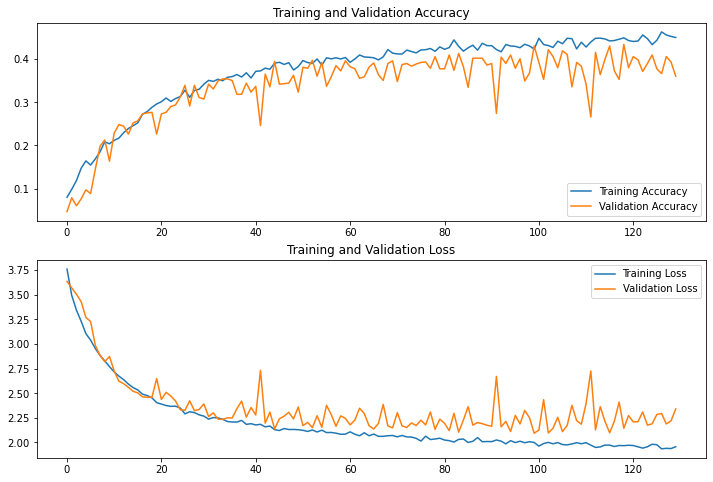

In [49]:
# 1st draft + regularizers and initializers
from keras import regularizers
# regularizers.l1_l2(l1=0.3,l2=0.5)
# initializer=tf.keras.initializers.HeUniform(seed=seed_value)
# adam=tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=0.000001) #ep=0.000001
# regular=tf.keras.regularizers.L1L2(l1=0.01,l2=0.01)
def conv_2d_pooling_layers(filters, kernel_size,conv_strides,activation,pool_size,pool_strides):
    return [
        tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=conv_strides,activation=activation
            ,kernel_regularizer='l2'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=conv_strides,activation=activation
            ,kernel_regularizer='l2'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=pool_size,strides=pool_strides)
        ,tf.keras.layers.Dropout(0.5,seed=seed_value) #0.5
    ]
# core_layers = \
#     conv_2d_pooling_layers(16, number_colour_layers) + \
#     conv_2d_pooling_layers(32, number_colour_layers) + \
#     conv_2d_pooling_layers(64, number_colour_layers)
core_layers = \
    conv_2d_pooling_layers(16, 2,1,'relu',2,2) + \
    conv_2d_pooling_layers(16, 3,1,'relu',2,2) + \
    conv_2d_pooling_layers(16, 5,1,'relu',2,2)
#6 16 5 kernel

dense_layers = [
    tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4,seed=seed_value),#0.4
    tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.1,seed=seed_value),
    tf.keras.layers.Dense(number_classes,activation='softmax')
]


model = tf.keras.Sequential(preprocessing_layers+data_augmentation +core_layers +dense_layers)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])
# model.compile(optimizer=adam,loss=loss,metrics=['accuracy'])


print("-"*25,"Model Summary","-"*25)
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto',
                                            baseline=None, restore_best_weights=True)
print("%%"*55)
print("##"*55)
print("-"*30,"Model Evaluation over Epochs","-"*30)
history = model.fit(training_ds["data"],validation_data = validation_ds["data"],epochs = 300,callbacks = [callback],shuffle=False)
print("%%"*55)

print("##"*55)
print("-"*25,"Test data evaluation","-"*25)
model.evaluate(test_ds["data"])
print("%%"*55)

print("##"*55)
print("-"*25,"Loss and Accuracy curves","-"*25)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Transfer learning

In [ ]:
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
# https://www.analyticsvidhya.com/blog/2021/11/transfer-learning-with-tensorflow/

In [2]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.20)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [3]:
train_data_generator = train_datagen.flow_from_directory(
    "/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/train_select",
    target_size=(256,256),
    subset='training'
    
)

valid_data_generator = train_datagen.flow_from_directory(
    "/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/train_select",
    target_size=(256,256),
    subset='validation'
)

test_data_generator = train_datagen.flow_from_directory(
    "/geode2/home/u010/adijames/Carbonate/Desktop/project/cipart_final/clipart/test_select",
    target_size=(256,256)
)

Found 3259 images belonging to 17 classes.
Found 806 images belonging to 17 classes.
Found 1756 images belonging to 17 classes.


In [6]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
resnet_50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
resnet_50.trainable=False

inputs = tf.keras.Input(shape=(256,256,3))
x = resnet_50(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(17, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Tranfer_learning")
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

Model: "Tranfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 17)                34833     
                                                                 
Total params: 23,622,545
Trainable params: 34,833
Non-trainable params: 23,587,712
_________________________________________________________________


------------------------------ Model Evaluation over Epochs ------------------------------
Epoch 1/10
102/102 [==============================] - 162s 2s/step - loss: 1.5966 - accuracy: 0.5244 - val_loss: 0.9848 - val_accuracy: 0.7345
Epoch 2/10
102/102 [==============================] - 156s 2s/step - loss: 0.7841 - accuracy: 0.7751 - val_loss: 0.8136 - val_accuracy: 0.7717
Epoch 3/10
102/102 [==============================] - 156s 2s/step - loss: 0.6020 - accuracy: 0.8260 - val_loss: 0.7830 - val_accuracy: 0.7829
Epoch 4/10
102/102 [==============================] - 158s 2s/step - loss: 0.4781 - accuracy: 0.8678 - val_loss: 0.7556 - val_accuracy: 0.7866
Epoch 5/10
102/102 [==============================] - 158s 2s/step - loss: 0.4025 - accuracy: 0.8929 - val_loss: 0.7552 - val_accuracy: 0.7866
Epoch 6/10
102/102 [==============================] - 156s 2s/step - loss: 0.3347 - accuracy: 0.9193 - val_loss: 0.7305 - val_accuracy: 0.8002
Epoch 7/10
102/102 [==============================]

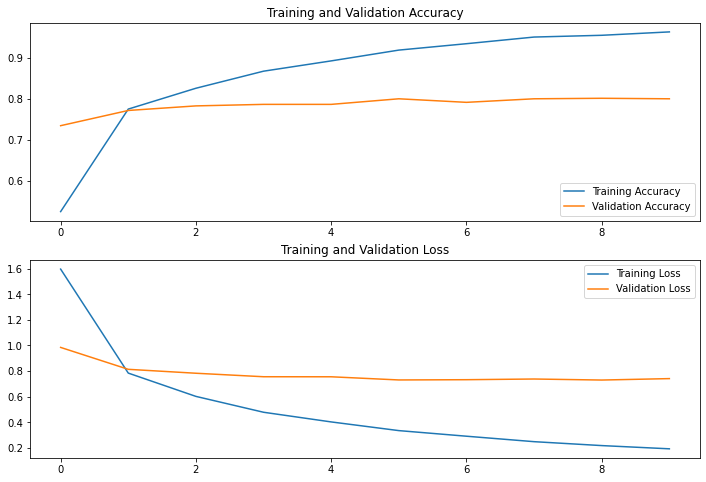

In [7]:
print("-"*30,"Model Evaluation over Epochs","-"*30)
history = model.fit(train_data_generator, validation_data=valid_data_generator, epochs=10)
print("%%"*55)

print("##"*55)
print("-"*25,"Test data evaluation","-"*25)
model.evaluate(test_data_generator)
print("%%"*55)


print("##"*55)
print("-"*25,"Loss and Accuracy curves","-"*25)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()